In [1]:
from deep_traffic_generation.tc_vae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset
from sklearn.preprocessing import MinMaxScaler

import pyvinecopulib as pv

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = TrafficDataset(
    "../deep_traffic_generation/data/traffic_15.pkl",
    features=["track_unwrapped", "groundspeed", "altitude", "timedelta"],
    init_features=["latitude", "longitude"],
    scaler=MinMaxScaler(feature_range=(-1, 1)),
    mode="image",
)
dataset

Dataset TrafficDataset
    Number of datapoints: 3968
    File location: ../deep_traffic_generation/data/traffic_15.pkl
    MinMaxScaler(feature_range=(-1, 1))

In [3]:
model = TCVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tc_vae/version_16/checkpoints/epoch=398-step=1196.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tc_vae/version_16/hparams.yaml",
    input_dim = dataset.input_dim,
    seq_len=dataset.seq_len,
    scaler = dataset.scaler,
)
model.eval()

TCVAE(
  (encoder): TCEncoder(
    (encoder): Sequential(
      (0): TCN(
        (network): Sequential(
          (0): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(4, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
          )
          (1): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
       

In [4]:
z_loc, z_scale = model.encoder(torch.Tensor(dataset.dense))
z_loc.size()

torch.Size([3968, 32])

In [5]:
np.save("../deep_traffic_generation/data/z_loc.npy", z_loc.detach().cpu().numpy())

In [6]:
z_loc = z_loc.detach().cpu().numpy()
# z_scale = np.exp(z_scale.detach().cpu().numpy() / 2)
z_loc

array([[-1.4225644 ,  2.0613804 ,  0.73520255, ..., -2.0336785 ,
        -0.57464164, -1.2076052 ],
       [ 0.9167501 , -0.2450345 , -0.45283526, ...,  1.1284189 ,
        -0.76716614, -0.66935384],
       [-1.1538975 , -0.12029746,  0.3121747 , ..., -0.61503434,
         0.21288474, -0.1518997 ],
       ...,
       [-0.2385302 , -0.43918774,  0.7789365 , ...,  0.04747355,
        -0.0251487 , -0.9464853 ],
       [-0.37033853, -0.9795581 ,  0.82650524, ..., -1.0967541 ,
         0.4293521 , -0.87835777],
       [-0.8202646 ,  0.78037125, -0.8443043 , ...,  0.14892787,
        -0.8875466 , -0.40428853]], dtype=float32)

In [7]:
transform = MinMaxScaler(feature_range=(0, 1))
z_loc = transform.fit_transform(z_loc)

In [8]:
z_loc[z_loc < 0] = 0.0
z_loc[z_loc > 1] = 1.0 

In [9]:
controls = pv.FitControlsVinecop(num_threads=4)
vine = pv.Vinecop(data=z_loc, controls=controls)
vine

<pyvinecopulib.Vinecop>
** Tree: 0
27,14 <-> BB1 90°, parameters =   1e-06
3.21548
16,2 <-> BB8 90°, parameters =  1.68148
0.999255
2,21 <-> BB8 270°, parameters =  1.73176
0.999128
31,22 <-> Student, parameters = 0.867649
 9.63323
14,24 <-> Student, parameters = 0.922118
 9.48375
20,24 <-> BB7 180°, parameters = 1.81556
2.75746
12,24 <-> Student, parameters = -0.555163
        2
9,8 <-> BB7 90°, parameters = 3.10987
2.52472
8,1 <-> Student, parameters = 0.932163
 4.78312
17,5 <-> BB7 270°, parameters = 1.67978
1.55322
3,24 <-> Student, parameters = -0.886868
   8.6238
32,30 <-> Student, parameters = 0.902207
 4.90328
28,26 <-> BB1 180°, parameters =   1e-06
3.60112
7,22 <-> BB7, parameters =   2.8112
0.489879
18,15 <-> Student, parameters = 0.899402
  4.8089
13,23 <-> Student, parameters = 0.884158
  10.094
6,23 <-> Student, parameters = -0.836826
  4.03297
15,26 <-> Student, parameters = 0.921958
 4.87707
11,1 <-> Student, parameters = 0.905828
 5.05681
30,26 <-> Student, parameters 

In [10]:
samples = vine.simulate(n=20, seeds=[42])
samples = torch.Tensor(transform.inverse_transform(samples))

In [11]:
# q = torch.distributions.Normal(z_loc[0], torch.exp(z_scale[0] / 2))
# samples = q.rsample().unsqueeze(0) 

In [12]:
samples.size()

torch.Size([20, 32])

In [13]:
outputs = model.decoder(samples)
outputs = torch.transpose(outputs, 1, 2)
outputs.size()

torch.Size([20, 200, 4])

In [14]:
data = outputs.detach().numpy()
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [15]:
from deep_traffic_generation.core.utils import traffic_from_data

# add latitude longitude info
info = np.ones((20, 2)) * 40
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)
traffic

,count
flight_id,
0,200
1,200
8,200
7,200
6,200
5,200
4,200
3,200
2,200


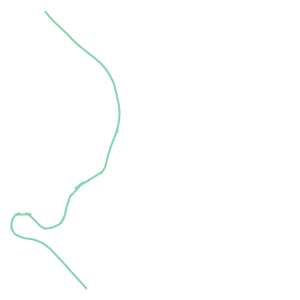

In [21]:
traffic[4]